In [2]:
# Loading relevant libraries 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import statsmodels.formula.api as sm
import matplotlib as mpl

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [4]:
# Filtering the dataset so that it only has not-readmitted vals
no_readmit = train[train['readmitted'] == 0]
readmit = train[train['readmitted'] == 1]

# Taking a random sample from the no_reamit df 
import random

n = 4982 # To get a 50-50 split, we need a sample of 5041
no_readmit1 = no_readmit.sample(n)

no_readmit.shape # (52173, 48)
readmit.shape # (5041, 48)
no_readmit1.shape # (5041, 48)

# Merging the no_readmit1 and readmit dfs to get a train1 df
merged_df = pd.concat([no_readmit1, readmit])
merged_df.shape

# Randomly shuffling the resulting df
train1 = merged_df.sample(frac=1)
train1.shape

(9964, 50)

In [5]:
# Fitting a prelim model
logit_model = sm.logit(formula = 'readmitted ~ time_in_hospital*age + num_of_changes + number_inpatient', data = train1).fit() #Developing logistic regression model
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.678695
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:                 9964
Model:                          Logit   Df Residuals:                     9958
Method:                           MLE   Df Model:                            5
Date:                Tue, 14 Mar 2023   Pseudo R-squ.:                 0.02085
Time:                        02:01:51   Log-Likelihood:                -6762.5
converged:                       True   LL-Null:                       -6906.5
Covariance Type:            nonrobust   LLR p-value:                 3.781e-60
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -1.0691      0.160     -6.672      0.000      -1.383      -0.755
time_in_hospital         0.0738      0.032      2.316      0.021       0.011       0.136
age                      0.0115      0.002      4.875      0.000       0.007       0.016
time_in_hospital:age    -0.0005      0.000     -1.108      0.268      -0.001       0.000
num_of_changes           0.1072      0.043      2.512      0.012       0.024       0.191
number_inpatient         0.3838      0.032     11.823      0.000       0.320       0.447
========================================================================================
"""

In [6]:
from sklearn.metrics import roc_curve, auc
y=train1.readmitted
ypred = logit_model.predict(train1)
fpr, tpr, auc_thresholds = roc_curve(y, ypred)
print(auc(fpr, tpr))# AUC of ROC

0.5932436256674167


In [7]:
from sklearn.metrics import roc_curve, auc

#Function to compute confusion matrix and prediction accuracy on test/train data
def confusion_matrix_data(data,actual_values,model,cutoff=0.5):
#Predict the values using the Logit model
    pred_values = model.predict(data)
# Specify the bins
    bins=np.array([0,cutoff,1])
#Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
# Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    fnr = (cm[1,0])/(cm[1,0]+cm[1,1])
    precision = (cm[1,1])/(cm[0,1]+cm[1,1])
    fpr = (cm[0,1])/(cm[0,0]+cm[0,1])
    tpr = (cm[1,1])/(cm[1,0]+cm[1,1])
    fpr_roc, tpr_roc, auc_thresholds = roc_curve(actual_values, pred_values)
    auc_value = (auc(fpr_roc, tpr_roc))# AUC of ROC
    mpl.rc('font', family='Arial', size=14)
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    print("Classification accuracy = {:.1%}".format(accuracy))
    print("Precision = {:.1%}".format(precision))
    print("TPR or Recall = {:.1%}".format(tpr))
    print("FNR = {:.1%}".format(fnr))
    print("FPR = {:.1%}".format(fpr))
    print("ROC-AUC = {:.1%}".format(auc_value))

Classification accuracy = 53.3%
Precision = 66.5%
TPR or Recall = 13.1%
FNR = 86.9%
FPR = 6.6%
ROC-AUC = 59.3%


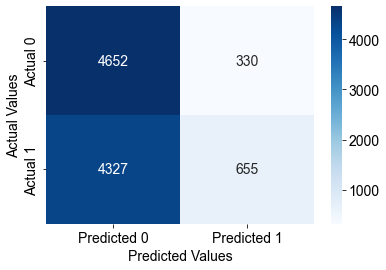

In [8]:
confusion_matrix_data(train1, train1.readmitted, logit_model, cutoff = auc(fpr, tpr))

Classification accuracy = 86.5%
Precision = 18.6%
TPR or Recall = 14.0%
FNR = 86.0%
FPR = 6.2%
ROC-AUC = 60.0%


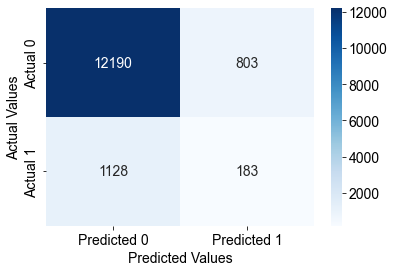

In [9]:
confusion_matrix_data(test,test.readmitted,logit_model, cutoff = auc(fpr, tpr))

Single model

In [10]:
train1_smote = pd.read_csv("train1_data_smotenc.csv")

In [14]:
train1_smote.head()

,Unnamed: 0,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,num_of_changes,readmitted
0,0,2278392,8222157,Caucasian,Female,5,5,18,1,1,...,No,No,No,No,No,No,No,No,0,0
1,1,149190,55629189,Caucasian,Female,15,1,1,7,3,...,Up,No,No,No,No,No,Ch,Yes,1,0
2,2,64410,86047875,AfricanAmerican,Female,25,1,1,7,2,...,No,No,No,No,No,No,No,Yes,0,0
3,3,500364,82442376,Caucasian,Male,35,1,1,7,2,...,Up,No,No,No,No,No,Ch,Yes,1,0
4,4,16680,42519267,Caucasian,Male,45,1,1,7,1,...,Steady,No,No,No,No,No,Ch,Yes,0,0


In [18]:
dummy_preds = ["age", "time_in_hospital", "admission_type_id", "discharge_disposition_id", "admission_source_id", "diag_1", "diag_2"]
train1_dummy = train1_smote.iloc[:, 1:].copy()
test_dummy = test.copy()
vars = []

for pred in dummy_preds:
    dummy_train = pd.get_dummies(train1_smote.loc[:, pred])
    dummy_train.columns = [pred + str(x) for x in dummy_train.columns]
    train1_dummy = pd.concat([train1_dummy, dummy_train], axis=1)
    vars.append(list(dummy_train.columns))
    
    dummy_test = pd.get_dummies(test.loc[:, pred])
    dummy_test.columns = [pred + str(x) for x in dummy_test.columns]
    test_dummy = pd.concat([test_dummy, dummy_test], axis=1)

In [19]:
train1_dummy

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,diag_2circulatory,diag_2diabetes,diag_2digestive,diag_2genitourinary,diag_2injury,diag_2musculoskeletal,diag_2neoplasms,diag_2other,diag_2pregnecy,diag_2respiratory
0,2278392,8222157,Caucasian,Female,5,5,18,1,1,?,...,0,0,0,0,0,0,0,1,0,0
1,149190,55629189,Caucasian,Female,15,1,1,7,3,?,...,0,1,0,0,0,0,0,0,0,0
2,64410,86047875,AfricanAmerican,Female,25,1,1,7,2,?,...,0,1,0,0,0,0,0,0,0,0
3,500364,82442376,Caucasian,Male,35,1,1,7,2,?,...,0,1,0,0,0,0,0,0,0,0
4,16680,42519267,Caucasian,Male,45,1,1,7,1,?,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104459,59711012,720382,Caucasian,Male,75,1,1,7,3,?,...,0,0,0,0,0,0,0,1,0,0
104460,143659228,97051808,Caucasian,Male,75,1,1,7,8,?,...,1,0,0,0,0,0,0,0,0,0
104461,75845268,34501851,Caucasian,Male,85,1,1,7,7,?,...,1,0,0,0,0,0,0,0,0,0
104462,117079971,75686609,Caucasian,Female,85,1,1,7,6,MC,...,0,0,0,0,0,0,0,1,0,0


In [16]:
# Examine whether there are multicollinear variables for variable selection
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = train1_dummy[['age5', 'age15', 'age25', 'age35', 'age45', 'age55',
       'age65', 'age75', 'age85', 'time_in_hospital1',
       'time_in_hospital2', 'time_in_hospital3', 'time_in_hospital4',
       'time_in_hospital5', 'time_in_hospital6', 'time_in_hospital7',
       'time_in_hospital8', 'time_in_hospital9', 'time_in_hospital10',
       'time_in_hospital11', 'time_in_hospital12', 'time_in_hospital13', 'admission_type_id1', 'admission_type_id3',
       'admission_type_id4', 'discharge_disposition_id7',
       'discharge_disposition_id10', 'discharge_disposition_id11',
       'discharge_disposition_id18', 'admission_source_id8',
       'admission_source_id9', 'number_inpatient', 'num_of_changes',  'diag_1circulatory',
       'diag_1diabetes', 'diag_1digestive', 'diag_1musculoskeletal', 'diag_1neoplasms', 'diag_1other', 'diag_1pregnecy', 'diag_1respiratory', 'diag_2circulatory', 'diag_2diabetes', 'diag_2digestive', 'diag_2musculoskeletal', 'diag_2neoplasms','diag_2other', 'diag_2pregnecy', 'diag_2respiratory']]
X = add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

for i in range(len(X.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(X.values, i)

In [20]:
model_5 = sm.logit(formula = 'readmitted ~ age5 + age15 + age25 + age45 + age55 + age65 + age75 + age85 + diag_1circulatory + diag_1diabetes + diag_1digestive + diag_1injury + diag_1musculoskeletal + diag_1neoplasms + diag_1other + diag_1pregnecy + time_in_hospital1 + time_in_hospital2 + time_in_hospital3 + time_in_hospital4 + time_in_hospital5 + time_in_hospital6 + time_in_hospital7 + time_in_hospital8 + time_in_hospital9 + time_in_hospital10 + time_in_hospital11 + time_in_hospital12 + time_in_hospital13 + discharge_disposition_id7 + discharge_disposition_id18 + admission_type_id1 + admission_type_id3 + num_of_changes + number_inpatient + diag_2circulatory + diag_2diabetes + diag_2digestive + diag_2injury + diag_2musculoskeletal + diag_2other', data = train1_dummy).fit() 
model_5.summary()

Optimization terminated successfully.
         Current function value: 0.623802
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:               104464
Model:                          Logit   Df Residuals:                   104422
Method:                           MLE   Df Model:                           41
Date:                Tue, 14 Mar 2023   Pseudo R-squ.:                  0.1000
Time:                        02:12:35   Log-Likelihood:                -65165.
converged:                       True   LL-Null:                       -72409.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -2.7392      0.092    -29.875      0.000      -2.919      -2.560
age5                          -2.8764      0.587     -4.901      0.000      -4.027      -1.726
age15                         -0.7324      0.132     -5.567      0.000      -0.990      -0.475
age25                         -0.2397      0.087     -2.765      0.006      -0.410      -0.070
age45                          0.3192      0.042      7.601      0.000       0.237       0.402
age55                          0.5080      0.038     13.353      0.000       0.433       0.583
age65                          0.9616      0.037     26.297      0.000       0.890       1.033
age75                          1.2130      0.036     33.679      0.000       1.142       1.284
age85                          1.0408      0.037     27.895      0.000       0.968       1.114
diag_1circulatory              0.8404      0.020     41.337      0.000       0.801       0.880
diag_1diabetes                 0.3648      0.031     11.628      0.000       0.303       0.426
diag_1digestive                0.0673      0.030      2.276      0.023       0.009       0.125
diag_1injury                   0.4244      0.031     13.644      0.000       0.363       0.485
diag_1musculoskeletal          0.2963      0.037      8.101      0.000       0.225       0.368
diag_1neoplasms                0.2181      0.043      5.034      0.000       0.133       0.303
diag_1other                    0.5297      0.023     22.603      0.000       0.484       0.576
diag_1pregnecy                -0.0654      0.145     -0.451      0.652      -0.350       0.219
time_in_hospital1              0.3141      0.081      3.865      0.000       0.155       0.473
time_in_hospital2              0.5875      0.081      7.277      0.000       0.429       0.746
time_in_hospital3              0.7020      0.081      8.710      0.000       0.544       0.860
time_in_hospital4              0.7584      0.081      9.364      0.000       0.600       0.917
time_in_hospital5              0.6684      0.082      8.171      0.000       0.508       0.829
time_in_hospital6              0.8306      0.082     10.073      0.000       0.669       0.992
time_in_hospital7              0.7184      0.084      8.588      0.000       0.554       0.882
time_in_hospital8              0.8350      0.085      9.790      0.000       0.668       1.002
time_in_hospital9              0.4700      0.089      5.268      0.000       0.295       0.645
time_in_hospital10             0.6839      0.091      7.490      0.000       0.505       0.863
time_in_hospital11             0.3170      0.096      3.294      0.001       0.128       0.506
time_in_hospital12             0.5041      0.100      5.065      0.000       0.309       0.699
time_in_hospital13             0.2316      0.106      2.177      0.029       0.023       0.440
discharge_disposition_id7     -1.7631      0.180     -9.791      0.000      -2.116      -1.410
discharge_d

In [21]:
y=train1_dummy.readmitted
ypred = model_5.predict(train1_dummy)
fpr, tpr, auc_thresholds = roc_curve(y, ypred)
print(auc(fpr, tpr))# AUC of ROC

0.7066196448276022


Classification accuracy = 56.6%
Precision = 73.2%
TPR or Recall = 20.8%
FNR = 79.2%
FPR = 7.6%
ROC-AUC = 70.7%


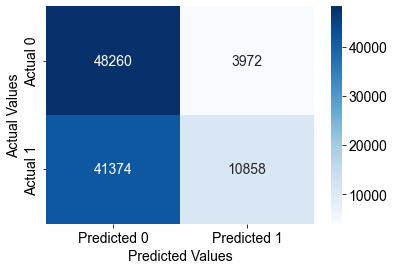

In [22]:
confusion_matrix_data(train1_dummy, train1_dummy.readmitted, model_5, cutoff = auc(fpr, tpr))

Classification accuracy = 85.3%
Precision = 13.3%
TPR or Recall = 11.1%
FNR = 88.9%
FPR = 7.3%
ROC-AUC = 54.4%


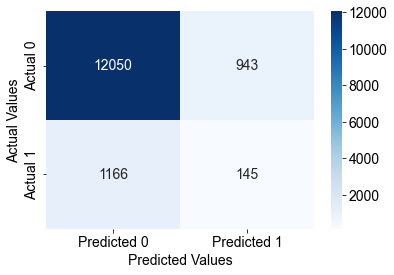

In [23]:
confusion_matrix_data(test_dummy,test_dummy.readmitted, model_5, cutoff = auc(fpr, tpr))